# TESTING OLD ARCHITECTURES FOR ASL

## Installing packages and downloading dataset

In [4]:
%pip install tensorflow 
%pip install matplotlib
%pip install opencv-python
%pip install numpy
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Develop

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras import Model

/Users/ezk/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
!wget https://media.githubusercontent.com/media/ayeshatasnim-h/Indian-Sign-Language-dataset/main/dataset_ISL.zip?download=true -O dataset_ISL.zip
!mkdir dataset_ISL
!unzip dataset_ISL.zip -d dataset_ISL

zsh:1: no matches found: https://media.githubusercontent.com/media/ayeshatasnim-h/Indian-Sign-Language-dataset/main/dataset_ISL.zip?download=true
mkdir: dataset_ISL: File exists
unzip:  cannot find or open dataset_ISL.zip, dataset_ISL.zip.zip or dataset_ISL.zip.ZIP.


In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [8]:
#quickly checking the number of classes
!find dataset_ISL -type d -mindepth 1 | wc -l
!rm -rf dataset_ISL/.DS_Store

      26


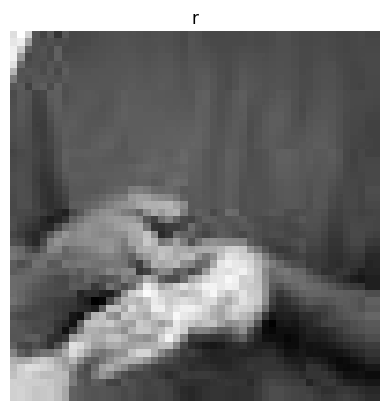

In [20]:
DATADIR = 'dataset_ISL'
CATEGORIES = os.listdir(DATADIR)
BATCH_SIZE = 128
#Visualizing the first image from the dataset
for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array,cmap='gray')
        plt.title(category)
        plt.axis('off')
        break
    break

In [19]:
#Re-sizing to 32x32 as per LeNet-5 architecture
IMG_SIZE = 32
X=[]
y=[]
training_data=[]
def create_training_data():
    training_data=[]
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
          img_array = cv2.imread(os.path.join(path,img))
          new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
          training_data.append([new_array,class_num])
    return training_data



In [11]:
# creating the target and features
def create_input(rgb):
    X=[]
    y=[]
    for feature,label in training_data:
        X.append(feature)
        y.append(label)
    if rgb:
        X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,3)
    else:
        X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)
    y_one_hot = tf.keras.utils.to_categorical(y,num_classes=len(CATEGORIES))
    y_one_hot = np.array(y_one_hot).reshape(-1,len(CATEGORIES))
    return X,y_one_hot

In [12]:
def data_augmentation(image,label,rgb=True):
    # Example data augmentation operations

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.1, upper=0.2)
    if not rgb:
      image = tf.image.rgb_to_grayscale(image)

    return image,label

In [13]:
#only for tf ds
def resizer(images,label,rgb=True):
    if not rgb:
        gray_imgs,_ = grayscaler(images,label)
    resized_images = np.array([cv2.resize(img, (IMG_SIZE,IMG_SIZE)) for img in gray_imgs])
    return resized_images, label

In [14]:
def grayscaler(images,label):
    grayscale_images = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    return grayscale_images,label

In [15]:
def normalizer(images,label): 
    images = np.array(images)/255
    return images,label

In [16]:
#only for tf ds
X_train,y_train = resizer(X_train,y_train,rgb=False)
X_test,y_test = resizer(X_test,y_test,rgb=False)
X_train,y_train = normalizer(X_train,y_train)
X_test,y_test = normalizer(X_test,y_test)
X_train = X_train.reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test = X_test.reshape(-1,IMG_SIZE,IMG_SIZE,1)
CATEGORIES = np.unique(y_train)
y_train = tf.keras.utils.to_categorical(y_train,num_classes=len(CATEGORIES))
y_train = np.array(y_train).reshape(-1,len(CATEGORIES))
y_test = tf.keras.utils.to_categorical(y_test,num_classes=len(CATEGORIES))
y_test = np.array(y_test).reshape(-1,len(CATEGORIES))

In [21]:
training_data=create_training_data()
random.shuffle(training_data)
X,y=create_input(rgb=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
X_train,y_train = data_augmentation(X_train,y_train,rgb=False)
X_test = tf.image.rgb_to_grayscale(X_test)

'c'

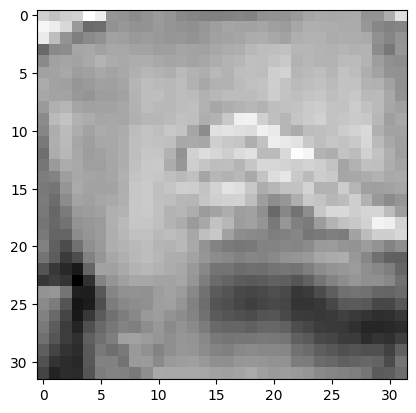

In [22]:
i=10
plt.imshow(np.array(X_train[i]),cmap='gray')
CATEGORIES[np.argmax(y_train[i])]

In [23]:
print('X_train :',X_train.shape)
print('y_train :',y_train.shape)
print('X_test :',X_test.shape)
print('test :',y_test.shape)

X_train : (10109, 32, 32, 1)
y_train : (10109, 26)
X_test : (2528, 32, 32, 1)
test : (2528, 26)


## LeNet-5


### NOTES :  

- LeNet-5 uses activations after pooling rather than after convolutions

- it pretty much exclusively uses tanh/sigmoid for activation except the  output layer

![LeNet-5](Assets/LeNet-5.svg)

In [94]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,1)),
    Conv2D(6,(5,5),1),
    AveragePooling2D((2,2),2),
    Activation('tanh'),
    Conv2D(16,(5,5),1),
    AveragePooling2D((2,2),2),
    Activation('tanh'),
    Flatten(),
    Dense(120,activation='tanh'),
    Dense(84,activation='tanh'),
    Dense(len(CATEGORIES),activation='softmax'),

])

In [95]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [96]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_10            │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_11            │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
History = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=20,
          validation_data=(X_test,y_test))

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2159 - loss: 2.1529 - val_accuracy: 0.2767 - val_loss: 2.0576
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2902 - loss: 2.0261 - val_accuracy: 0.3178 - val_loss: 1.9723
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3236 - loss: 1.9189 - val_accuracy: 0.3477 - val_loss: 1.8350
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3631 - loss: 1.8047 - val_accuracy: 0.3728 - val_loss: 1.7692
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3918 - loss: 1.7283 - val_accuracy: 0.3903 - val_loss: 1.7195
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4133 - loss: 1.6635 - val_accuracy: 0.4024 - val_loss: 1.6897
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4317 - loss: 1.6101 - val_accuracy: 0.4091 - val_loss: 1.6548
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4451 - loss: 1.5708 - val_accu

313/313 - 0s - 1ms/step - accuracy: 0.4445 - loss: 1.6151


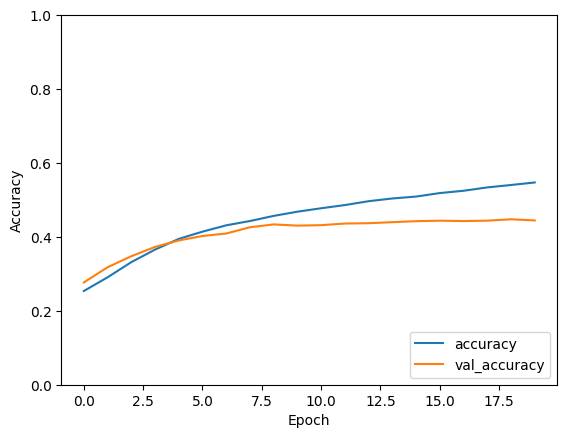

In [98]:
plt.plot(History.history['accuracy'], label='accuracy')
plt.plot(History.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
model prediction : 6


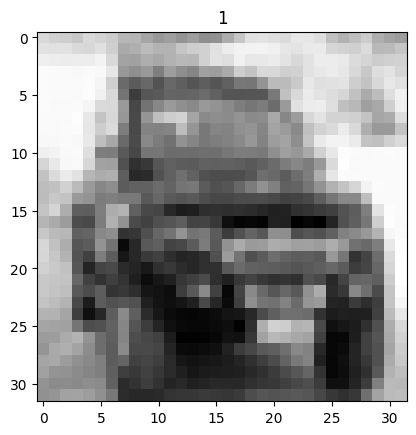

In [104]:
i=9
plt.title(CATEGORIES[np.argmax(y_test[i])])
plt.imshow(X_test[i],cmap='gray')
print('model prediction :',CATEGORIES[np.argmax(model.predict(np.array(X_test[i]).reshape(-1,32,32,1)))])

In [91]:
model.save('models/LeNet5.keras')

### ANALYSIS :
- firstly the dataset is quite small for from scratch training of ASL , normally one would use this on a pre-trained model and its hard not to overfit the dataset

- 32x32 images as input are bad in this situation, even the human eye can barely differentiate a lot of the ASL signs. 1 and r for example

- the data augmentation for training set helps mitigate the overfitting to an extent but as soon as input goes beyond 32x32 , the model seemingly overfits training set

- LeNet-5 also uses way less parameters compared to modern CNNs and also uses some weird techniques like activating after pooling

## ALEXNET

![AlexNet](Assets/AlexNet.svg)

In [112]:
#using a generator to feed input images rather than loading all the images to RAM(RGB images take 3x the RAM)
IMG_SIZE=227
train = tf.keras.preprocessing.image_dataset_from_directory(
    DATADIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CATEGORIES,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=24,
    validation_split = 0.1,
    subset = 'training'
    )

Found 12637 files belonging to 26 classes.
Using 11374 files for training.


In [29]:
val = tf.keras.preprocessing.image_dataset_from_directory(
    DATADIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CATEGORIES,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=24,
    validation_split = 0.1,
    subset = 'validation'
    )

Found 12637 files belonging to 26 classes.
Using 1263 files for validation.


In [30]:
train=train.map(data_augmentation)

NameError: name 'data_augmentation' is not defined

In [31]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    Activation('relu'),
    MaxPool2D(pool_size=(3,3),strides=(2,2)),
    Conv2D(filters=256,kernel_size=(5,5),padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    Activation('relu'),
    MaxPool2D(pool_size=(3,3),strides=(2,2)),
    Conv2D(filters=384,kernel_size=(3,3),padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    Activation('relu'),
    Conv2D(filters=384,kernel_size=(3,3),padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    Activation('relu'),
    Conv2D(filters=256,kernel_size=(3,3),padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    Activation('relu'),
    MaxPool2D(pool_size=(3,3),strides=(2,2)),
    Flatten(),
    Dense(units=4096,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),),
    Dense(units=4096,activation='relu',),
    Dense(units=len(CATEGORIES),activation='softmax'),

])

In [100]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [101]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 26)             │       106,522 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,387,866 (222.73 MB)

 Trainable params: 58,387,866 (222.73 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
History = model.fit(train,
                     batch_size=BATCH_SIZE,
                     epochs=20,
                     validation_data=[val]
                     )

Epoch 1/20
 22/356 ━━━━━━━━━━━━━━━━━━━━ 5:17 950ms/step - accuracy: 0.0385 - loss: 154.7277

KeyboardInterrupt: 

134/134 - 3s - 24ms/step - accuracy: 0.8514 - loss: 1.8768


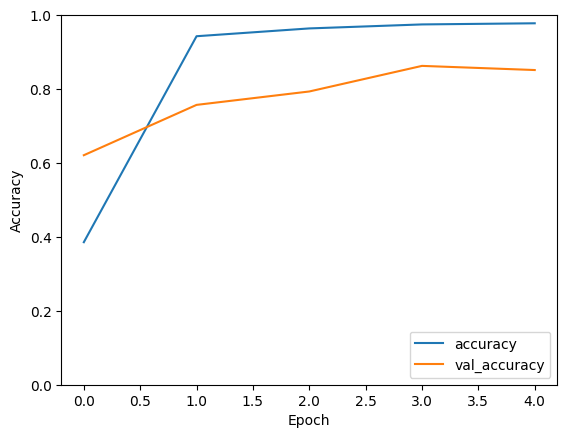

In [ ]:
plt.plot(History.history['accuracy'], label='accuracy')
plt.plot(History.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(val, verbose=2)

In [ ]:
model.save('models/AlexNet.keras')

## VGG-16

In [5]:
IMG_SIZE = 224

In [21]:
model= tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(64,(3,3),padding='same',activation='relu'),
    Conv2D(64,(3,3),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(128,(3,3),padding='same',activation='relu'),
    Conv2D(128,(3,3),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(256,(3,3),padding='same',activation='relu'),
    Conv2D(256,(3,3),padding='same',activation='relu'),
    Conv2D(256,(3,3),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(512,(3,3),padding='same',activation='relu'),
    Conv2D(512,(3,3),padding='same',activation='relu'),
    Conv2D(512,(3,3),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(512,(3,3),padding='same',activation='relu'),
    Conv2D(512,(3,3),padding='same',activation='relu'),
    Conv2D(512,(3,3),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(4096,activation='relu'),
    Dense(4096,activation='relu'),
    Dense(len(CATEGORIES),activation='relu')
])

In [22]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [23]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 26)             │       106,522 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,367,066 (512.57 MB)

 Trainable params: 134,367,066 (512.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
History = model.fit(train,
                     batch_size=BATCH_SIZE,
                     epochs=20,
                     validation_data=[val]
                     )

In [ ]:
plt.plot(History.history['accuracy'], label='accuracy')
plt.plot(History.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(val, verbose=2)

In [ ]:
model.save('models/VGG16.keras')

## RESNET-18

In [39]:
IMG_SIZE = 224

In [40]:
#using a generator to feed input images rather than loading all the images to RAM(RGB images take 3x the RAM)
train = tf.keras.preprocessing.image_dataset_from_directory(
    DATADIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CATEGORIES,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=24,
    validation_split = 0.1,
    subset = 'training'
    )

Found 12637 files belonging to 26 classes.
Using 11374 files for training.


In [41]:
val = tf.keras.preprocessing.image_dataset_from_directory(
    DATADIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CATEGORIES,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=24,
    validation_split = 0.1,
    subset = 'validation'
    )

Found 12637 files belonging to 26 classes.
Using 1263 files for validation.


In [42]:
train=train.map(data_augmentation)

In [51]:
def basic_block(x,planes,stride=1,downsample=None):
    identity = x 
    out = ZeroPadding2D(padding=1)(x)
    out = Conv2D(filters=planes,kernel_size=3,strides=stride,use_bias=False)(out)
    out = BatchNormalization(momentum=0.9,epsilon = 1e-5)(out)
    out = ReLU()(out)
    out = ZeroPadding2D(padding=1)(out)
    out = Conv2D(filters=planes,kernel_size=3,strides=1,use_bias=False)(out)
    out = BatchNormalization(momentum=0.9,epsilon = 1e-5)(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)
    out  = tf.keras.layers.Add()([identity,out]) #skip connection
    out = ReLU()(out)

    return out


In [52]:
def ResBlock(x, planes,blocks,strides=1):
    inplanes = x.shape[-1]
    downsample = None
    
    if strides != 1 or inplanes != planes:
        downsample = [
            Conv2D(filters=planes, kernel_size=1, strides=strides, use_bias=False, padding='same'),
            BatchNormalization(momentum=0.9, epsilon=1e-5)
        ]
    x = basic_block(x, planes, stride=strides, downsample=downsample)
    for i in range(1, blocks):
        x = basic_block(x, planes)
    return x


In [53]:
input = Input((224,224,3))
x = ZeroPadding2D(padding=3)(input)
x = Conv2D(filters=64,kernel_size=7,strides=2,use_bias=False)(x)
x = BatchNormalization(momentum=0.9,epsilon = 1e-5)(x)
x = ReLU()(x)
x = ZeroPadding2D(padding=1)(x)
x = MaxPool2D(pool_size = 3,strides = 2)(x)
x = ResBlock(x,64,blocks=2)
x = ResBlock(x,128,strides=2,blocks=2)
x = ResBlock(x,256,strides=2,blocks=2)
x = ResBlock(x,512,strides=2,blocks=2)
x = GlobalAveragePooling2D()(x)
x = Dense(units=len(CATEGORIES))(x)

In [54]:
model = tf.keras.Model(input,x)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [55]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_72   │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 112, 112,  │      9,408 │ zero_padding2d_7… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_80[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_68 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_73   │ (None, 114, 114,  │          0 │ re_lu_68[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_74   │ (None, 58, 58,    │          0 │ max_pooling2d_4[… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 56, 56,    │     36,864 │ zero_padding2d_7… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_81[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_69 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_75   │ (None, 58, 58,    │          0 │ re_lu_69[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 56, 56,    │     36,864 │ zero_padding2d_7… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_82[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 56, 56,    │          0 │ max_pooling2d_4[… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_70 (ReLU)     │ (None, 56, 56,    │          0 │ add_32[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_76   │ (None, 58, 58,    │          0 │ re_lu_70[0][0]  

 Total params: 11,199,450 (42.72 MB)

 Trainable params: 11,189,850 (42.69 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [58]:
History = model.fit(train,
                     batch_size=BATCH_SIZE,
                     epochs=20,
                     validation_data=[val]
                    )

Epoch 1/20
  7/356 ━━━━━━━━━━━━━━━━━━━━ 10:24 2s/step - accuracy: 0.0186 - loss: 7.5975

KeyboardInterrupt: 

In [96]:
input = Input((224,224,3))
res = resnet18(input)
model = keras.Model(input,res)

In [97]:
model.summary()

Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_65      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_18   │ (None, 230, 230,  │          0 │ input_layer_65[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_139 (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_139[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_19   │ (None, 114, 114,  │          0 │ re_lu_24[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_20   │ (None, 58, 58,    │          0 │ max_pooling2d_8[… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_140 (Conv2D) │ (None, 56, 56,    │     36,864 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_140[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_21   │ (None, 58, 58,    │          0 │ re_lu_25[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_141 (Conv2D) │ (None, 56, 56,    │     36,864 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_141[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 56, 56,    │          0 │ max_pooling2d_8[… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 56, 56,    │          0 │ add_8[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_22   │ (None, 58, 58,    │          0 │ re_lu_26[0][0]  

 Total params: 11,199,450 (42.72 MB)

 Trainable params: 11,189,850 (42.69 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [98]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [99]:
History = model.fit(train,
                     batch_size=BATCH_SIZE,
                     epochs=20,
                     validation_data=[val]
                    )

Epoch 1/20
 41/356 ━━━━━━━━━━━━━━━━━━━━ 9:15 2s/step - accuracy: 0.0506 - loss: 5.9648

KeyboardInterrupt: 

# Note: 

The diagrams of residual blocks can be misleading. Although they may appear to skip over multiple layers, in practice, the skip connection's 

additive operation occurs at each skipped layer individually. This means that each layer in the residual block is processed as follows: the output 

of the layer plus the identity of the layer is used to update the output. Essentially, the process can be summarized as 

output = output + identity

output= output+identity at each layer, with the final result being a combination of the original input and the accumulated outputs of each skipped 

layer.

## GoogleNet


In [35]:
IMG_SIZE = 224

In [36]:
#using a generator to feed input images rather than loading all the images to RAM(RGB images take 3x the RAM)
train = tf.keras.preprocessing.image_dataset_from_directory(
    DATADIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CATEGORIES,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=24,
    validation_split = 0.1,
    subset = 'training'
    )

Found 12637 files belonging to 26 classes.
Using 11374 files for training.


In [37]:
#using a generator to feed input images rather than loading all the images to RAM(RGB images take 3x the RAM)
val = tf.keras.preprocessing.image_dataset_from_directory(
    DATADIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CATEGORIES,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=24,
    validation_split = 0.1,
    subset = 'validation'
    )

Found 12637 files belonging to 26 classes.
Using 1263 files for validation.


In [38]:
train=train.map(data_augmentation)

In [39]:
def inception(x, filters):
    conv_1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    
    reducer_conv_5x5 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters[2], (5, 5), padding='same', activation='relu')(reducer_conv_5x5)
    
    reducer_conv_3x3 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters[4], (3, 3), padding='same', activation='relu')(reducer_conv_3x3)
    
    conv_pooler = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv_pooled_1x1 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(conv_pooler)
    
    inception_out = concatenate([conv_1x1, conv_5x5, conv_3x3, conv_pooled_1x1], axis=-1)
    
    return inception_out


In [40]:
def local_response_normalization(x):
    return tf.nn.local_response_normalization(x)

In [70]:
input = Input((IMG_SIZE,IMG_SIZE,3))
x = Conv2D(64, (7,7), strides=2, padding='same',activation='relu')(input)
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
x = Lambda(local_response_normalization)(x)
x = Conv2D(64, (1,1), strides=1, padding='same')(x)
x = Conv2D(192, (3,3), strides=1, padding='same')(x)
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

x = Lambda(local_response_normalization)(x)
x = inception(x, [64,16,32,96,128,32])
x = inception(x, [128,32,96,128,192,64])
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
x = inception(x, [192,16,48,96,208,64])


soft0 = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
soft0 = Conv2D(64, (1,1), strides=1, padding='same')(soft0)
soft0 = Flatten()(soft0)
soft0 = Dense(1024, activation='relu')(soft0)
soft0 = Dropout(0.7)(soft0)
soft0 = Dense(len(CATEGORIES), activation='softmax')(soft0)

x = inception(x, [128,24,64,128,256,64])
x = inception(x, [112,32,64,144,288,64])
x = inception(x, [256,32,128,160,320,128])

soft1 = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
soft1 = Conv2D(64, (1,1), strides=1, padding='same')(soft1)
soft1 = Flatten()(soft1)
soft1 = Dense(1024, activation='relu')(soft1)
soft1 = Dropout(0.7)(soft1)
soft1 = Dense(len(CATEGORIES), activation='softmax')(soft1)


x = inception(x, [256,32,128,160,320,128])
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
x = inception(x, [256,32,128,160,320,128])
x = inception(x, [256,32,128,160,320,128])


x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(len(CATEGORIES), activation='softmax')(x)


model = Model(inputs=input, outputs=[x,soft0,soft1])


In [71]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','accuracy','accuracy'],
)

In [72]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_590 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_18[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_130   │ (None, 56, 56,    │          0 │ conv2d_590[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_20 (Lambda)  │ (None, 56, 56,    │          0 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_591 (Conv2D) │ (None, 56, 56,    │      4,160 │ lambda_20[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_592 (Conv2D) │ (None, 56, 56,    │    110,784 │ conv2d_591[0][0]  │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_131   │ (None, 28, 28,    │          0 │ conv2d_592[0][0]  │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_21 (Lambda)  │ (None, 28, 28,    │          0 │ max_pooling2d_13… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_594 (Conv2D) │ (None, 28, 28,    │      3,088 │ lambda_21[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_596 (Conv2D) │ (None, 28, 28,    │     18,528 │ lambda_21[0][0]   │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_132   │ (None, 28, 28,    │          0 │ lambda_21[0][0]   │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_593 (Conv2D) │ (None, 28, 28,    │     12,352 │ lambda_21[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_595 (Conv2D) │ (None, 28, 28,    │     12,832 │ conv2d_594[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_597 (Conv2D) │ (None, 28, 28,    │    110,720 │ conv2d_596[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_598 (Conv2D) │ (None, 28, 28,    │      6,176 │ max_pooling2d_13… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_90      │ (None, 28, 28,    │          0 │ conv2d_593[0][0], │
│ (Concatenate)       │ 256)              │            │ conv2d_595[0][0], │
│                     │                   │            │ conv2d_597[0][0], │
│                     │                   │            │ conv2d_598[0][0]

 Total params: 8,427,526 (32.15 MB)

 Trainable params: 8,427,526 (32.15 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
History = model.fit(train,
                     batch_size=BATCH_SIZE,
                     epochs=20,
                     validation_data=[val]
                    )

Epoch 1/20


/Users/ezk/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?


  4/356 ━━━━━━━━━━━━━━━━━━━━ 8:36 1s/step - dense_62_accuracy: 0.0378 - loss: 3.2631

KeyboardInterrupt: 

## MobileNet V1

In [40]:
IMG_SIZE = 224

In [41]:
#using a generator to feed input images rather than loading all the images to RAM(RGB images take 3x the RAM)
train = tf.keras.preprocessing.image_dataset_from_directory(
    DATADIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CATEGORIES,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=24,
    validation_split = 0.1,
    subset = 'training'
    )

Found 12637 files belonging to 26 classes.
Using 11374 files for training.


In [42]:
#using a generator to feed input images rather than loading all the images to RAM(RGB images take 3x the RAM)
val = tf.keras.preprocessing.image_dataset_from_directory(
    DATADIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CATEGORIES,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=24,
    validation_split = 0.1,
    subset = 'validation'
    )

Found 12637 files belonging to 26 classes.
Using 1263 files for validation.


In [43]:
train=train.map(data_augmentation)

In [67]:
def depthwise_separable_conv(x,kernel_size,padding,filters,strides=1):
    x  = DepthwiseConv2D(kernel_size=kernel_size,strides=strides,padding = padding)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters = filters,kernel_size=(1,1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [69]:
input = Input((IMG_SIZE, IMG_SIZE, 3))

x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(input)  
x = depthwise_separable_conv(x, filters=64, kernel_size=(3, 3), padding='same')  
x = depthwise_separable_conv(x, filters=128, kernel_size=(3, 3), padding='same', strides=(2, 2))  
x = depthwise_separable_conv(x, filters=128, kernel_size=(3, 3), padding='same')  
x = depthwise_separable_conv(x, filters=256, kernel_size=(3, 3), padding='same', strides=(2, 2))  
x = depthwise_separable_conv(x, filters=256, kernel_size=(3, 3), padding='same')  
x = depthwise_separable_conv(x, filters=512, kernel_size=(3, 3), padding='same', strides=(2, 2))  
x = depthwise_separable_conv(x, filters=512, kernel_size=(3, 3), padding='same')  
x = depthwise_separable_conv(x, filters=512, kernel_size=(3, 3), padding='same')  
x = depthwise_separable_conv(x, filters=512, kernel_size=(3, 3), padding='same')  
x = depthwise_separable_conv(x, filters=512, kernel_size=(3, 3), padding='same')  
x = depthwise_separable_conv(x, filters=512, kernel_size=(3, 3), padding='same')  
x = depthwise_separable_conv(x, filters=1024, kernel_size=(3, 3), padding='same', strides=(2, 2))  
x = depthwise_separable_conv(x, filters=1024, kernel_size=(3, 3), padding='same')  

x = AveragePooling2D((7, 7))(x)  
x = Flatten()(x)  
x = Dense(1024, activation='relu')(x)  
x = Dense(len(CATEGORIES), activation='softmax')(x)  



In [70]:
model = Model(inputs=input, outputs=x)

In [71]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','accuracy','accuracy'],
)

In [72]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_83             │ (None, 112, 112, 32)   │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_162         │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 112, 112, 64)   │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_163         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_80 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_84             │ (None, 56, 56, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_164         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 56, 56, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_165         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_81 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_85             │ (None, 56, 56, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_166         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 56, 56, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_167         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_82 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_86             │ (None, 28, 28, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_168         │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,315,930 (16.46 MB)

 Trainable params: 4,294,106 (16.38 MB)

 Non-trainable params: 21,824 (85.25 KB)

In [73]:
History = model.fit(train,
                     batch_size=BATCH_SIZE,
                     epochs=20,
                     validation_data=[val]
                    )

Epoch 1/20
25/89 ━━━━━━━━━━━━━━━━━━━━ 7:11 7s/step - accuracy: 0.0769 - accuracy_1: 0.0769 - accuracy_2: 0.0769 - loss: 3.3314

KeyboardInterrupt: 